In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from copy import deepcopy
from lifelines.statistics import logrank_test
%config InlineBackend.figure_format = 'retina'
import numpy as np
import seaborn as sns
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from scipy.stats import pearsonr
import sys
import warnings
from collections import Counter
from statannot import add_stat_annotation
from statsmodels.stats.multitest import multipletests
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Clean up metadata

In [2]:
# clean up metadata
df_meta = pd.read_csv('qiime2_output/SraRunTable.txt')
df_meta = df_meta[['Run', 'sample_name','host_subject_id','timepoint','treatment']]
df_meta.columns = ['Run','Sample_Name','host_subject_id','Timepoint','Treatment']
df_meta.columns = ['SRA','SampleID','SubjectID','Timepoint','Antibiotic']
df_meta['BodySite'] = 'Gastrointestinal_tract'
df_meta['BodySubSite'] = 'Stool'
table1= [['SGD','0-29','A',16,'Male','Leukemia','MUD 10/10','PBSC',np.nan,7,'Staphylococcus epidermidis (5), Klebsiella pneumoniae (4), Klebsiella ornitholytica (1), Enterococcus faecalis (1), Candida orthopsilosis (1)','Van,Caz,Vcz','GI/Skin GVHD'],
         ['SGD','0-28','B',16,'Male','Leukemia','HLA-identical','Bone marrow','Donor 2',1,'Staphylococcus epidermidis (1)','Vcz',np.nan],
         ['SGD','0-29','C',17,'Male','Benign hematology','HLA-identical','Bone marrow',np.nan,np.nan,np.nan,'Van,Caz','Skin GVHD'],
         ['SGD','0-35','D',8,'Male','Benign hematology','HLA-identical','Bone marrow',np.nan,np.nan,np.nan,'Amx,Van,Caz',np.nan],
         ['SGD','0-21','E',8,'Female','Benign hematology','Haploidentical','PBSC',np.nan,2,'Streptococcus mitis (1), Staphylococcus aureus (1), Klebsiella pneumoniae (1), Acinetobacter baumannii (1)','Van,Caz',np.nan],
         ['SGD','0-37','F',10,'Male','Benign hematology','HLA-identical','Bone marrow','Donor 3',1,'Actinomyces oris (1)','Van,Caz',np.nan],
         ['SGD','0-26','G',11,'Male','MDS','HLA-identical','Bone marrow','Donor 1',np.nan,np.nan,'Van,Caz',np.nan],
         ['TGD','0-23','H',3,'Female','Leukemia','MUD 10/10','Bone marrow',np.nan,1,'Lachnoanaerobaculum orale (1)','Van,Caz,Vcz',np.nan],
         ['TGD','0-30','I',14,'Female','Leukemia','MUD 10/10','Bone marrow',np.nan,np.nan,np.nan,'Van,Caz,Vcz',np.nan],
         ['TGD','0-36','J',7,'Female','MDS','MUD 10/10','Bone marrow',np.nan,np.nan,np.nan,'Van,Caz',np.nan],
         ['TGD','0-30','K',15,'Female','MDS','MUD 9/10','Bone marrow',np.nan,np.nan,np.nan,'Amx,Van,Caz',np.nan],
         ['TGD','0-32','L',15,'Female','MDS','HLA-identical','Bone marrow',np.nan,np.nan,np.nan,np.nan,np.nan],
         ['TGD','0-40','M',1,'Female','PI','MUD 6/10','Cord blood',np.nan,1,'Bacillus simplex (1)','Van,Vcz',np.nan],
         ['TGD','0-28','N',13,'Female','Leukemia','MUD','Bone marrow',np.nan,np.nan,np.nan,'Van,Caz,Vcz','Skin GVHD'],
         ['TGD','0-30','O',11,'Male','PI','HLA-identical','Bone marrow',np.nan,np.nan,np.nan,'Van,Caz',np.nan],
         ['TGD','0-49','P',1,'Female','PI','MUD 9/10','Bone marrow',np.nan,np.nan,np.nan,'Amx,Van,Caz',np.nan],
         ['TGD','0-35','Q',13,'Male','Benign hematology','MUD 10/10','Bone marrow',np.nan,3,'Moraxella (2), Microbacterium paraoxydans (2), Streptococcus mitis (1), Staphylococcus epidermidis (1)','Amx,Van,Caz',np.nan],
         ['TGD','0-31','R',1,'Male','Leukemia','MUD 10/10','Bone marrow',np.nan,np.nan,np.nan,'Amx,Van,Caz',np.nan],
         ['TGD','0-36','S',12,'Female','MDS','MUD 10/10','Bone marrow',np.nan,np.nan,np.nan,'Van,Caz',np.nan]]
df_table1 = pd.DataFrame(table1, columns=['Antibiotic','AntibioticWhen','SubjectID','Age','Gender','Disease','HCTDonor','HCTSource','DonorID','BSI_Episodes(BacteremiaDay)','InfectiousAgent','Antibiotic2','Comorbidity'])
df_meta = pd.merge(df_meta, df_table1, left_on=['Antibiotic','SubjectID'], right_on=['Antibiotic','SubjectID'], how='left')
df_meta = df_meta[~df_meta.SubjectID.str.contains('Donor')] # remove samples from Donor
df_meta.AntibioticWhen = ['From day %s to day %s'%(x.split('-')[0], x.split('-')[1]) if str(x)!='nan' else np.NaN for x in df_meta.AntibioticWhen]
df_meta['Medication'] = np.NaN
df_meta['MedicationWhen'] = np.NaN
df_meta.loc[df_meta.Antibiotic=='TGD','Medication'] = 'Symbiolact(oral)--Lactobacillus acidophilus,Lactobacillus paracasei,Bifidobacterium lactis'
df_meta.loc[df_meta.Antibiotic=='TGD','MedicationWhen'] = 'After TGD'
df_meta['Treatment'] = 'Allogeneic stem cell transplantation'
df_meta['TreatmentWhen'] = 'Day 10'
df_meta.loc[df_meta.Antibiotic=='TGD','Antibiotic'] = 'TGD(oral)--piperacillin/tazobactam,amphotericin B'
df_meta.loc[df_meta.Antibiotic=='SGD','Antibiotic'] = 'SGD(oral)--polymyxin/neomycin,amphotericin B'
df_meta['RefDate'] = 'First day of TGD/SGD'
df_meta['SequencingAssay'] = 'Amplicon'
df_meta['Study'] = 'bmt_bekker2019_bbmt'
df_meta['PatientGeo'] = 'Netherlands'
df_meta['Timepoint'] = ['Day %s'%(str(int(x))) if str(x)!='nan' else np.NaN for x in df_meta.Timepoint]
df_meta.loc[df_meta.Disease=='MDS','Disease'] = 'Myelodysplastic syndrome'
df_meta.loc[df_meta.Disease=='PI','Disease'] = 'Primary immunodeficiency'
new_infagent = []
for ia in df_meta.InfectiousAgent:
    if str(ia)=='nan':
        new_infagent.append(np.NaN)
    else:
        new_infagent.append((',').join([y.split('(')[0].strip() for y in ia.split(',')]))
df_meta['InfectiousAgent'] = new_infagent
df_meta['InfectionLocation'] = np.NaN
df_meta.loc[df_meta.InfectiousAgent.notnull(), 'InfectionLocation'] = 'Blood'
new_med = []
new_med_when = []
for x,y,z in zip(df_meta.Antibiotic2,df_meta.Antibiotic,df_meta.AntibioticWhen):
    if str(x)=='nan':
        new_med.append(y)
        new_med_when.append(z)
    else:
        x1 = x.replace('Van','Vancomycin').replace('Caz','Ceftazidime').replace('Amx','Amoxicillin').replace('Vcz','Voriconazole')
        x1 = (',').join([x2 for x2 in x1.split(',')])
        new_med.append(y+','+x1)
        new_med_when.append(z+('').join([',']*len(x1.split(','))))
df_meta['Antibiotic'] = new_med
df_meta['AntibioticWhen'] = new_med_when

df_meta.head()

,SRA,SampleID,SubjectID,Timepoint,Antibiotic,BodySite,BodySubSite,AntibioticWhen,Age,Gender,...,Comorbidity,Medication,MedicationWhen,Treatment,TreatmentWhen,RefDate,SequencingAssay,Study,PatientGeo,InfectionLocation
0,ERR2888357,Sample1,A,Day 11,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,...,GI/Skin GVHD,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood
1,ERR2888358,Sample2,A,Day 17,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,...,GI/Skin GVHD,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood
2,ERR2888359,Sample5,A,Day 22,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,...,GI/Skin GVHD,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood
3,ERR2888360,Sample6,A,Day 29,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,...,GI/Skin GVHD,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood
4,ERR2888361,Sample9,A,Day 74,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,...,GI/Skin GVHD,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood


# Compute oral bacterial fraction

## Read taxonomy

In [3]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,9908fffab7ed4f3bec44cda2f5084d49,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.984443,g__Enterococcus
1,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
2,65d43491988bfe557da4d86a5ba25dae,d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...,0.990334,g__Staphylococcus
3,2c982937754e6321f861027032db80f7,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999999,g__Bacteroides
4,fd44d4cb468fd7dc9b3227867714ed87,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides


## Read count data (filter out samples with less than 1000 reads)

In [4]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.SRA).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 63717


#OTU ID,9908fffab7ed4f3bec44cda2f5084d49,99deb3c5ecb022ec05609ebd1112a557,65d43491988bfe557da4d86a5ba25dae,2c982937754e6321f861027032db80f7,fd44d4cb468fd7dc9b3227867714ed87,c6c3ab4e828fb40d6e05967b7aac9338,76b39e86c95e0c7dd8b9c57b974f6532,333bbf9224442fc10cd497377d2b1d01,fd496fd32dc8c08ade2e8b6c9d8ee13d,945184b6386c192c0066e0a98a154780,...,496ab21e352a1c8c60c29b6e5358554d,49b51b2a82d2db04670e46e52645b17d,03d53da73e2830a88c0707f636b6aad7,0f498e3088016e1f02e37313241535f3,46ec1ddbc8b38f394fd8bf2d595d15f9,3e59b131fdf36a3d5baa286988d470c3,a77322802d618414e15175bde13f87fe,52dc247367c2bd0ce1f6d9e6ead26304,2695966d791f54bcbae40b7306abc5d8,749f10c2990a1f631d0d8da42b247117
ERR2888378,0.111436,0.000280,0.000000,0.000040,0.000000,0.000000,0.147011,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2888561,0.000267,0.000000,0.000000,0.000537,0.000662,0.000000,0.000254,0.000604,0.111596,0.000181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2888464,0.005792,0.000000,0.000000,0.000000,0.542018,0.000000,0.086630,0.000076,0.000056,0.000256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2888420,0.000553,0.030201,0.000349,0.000000,0.000000,0.000000,0.000806,0.000611,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2888563,0.118756,0.000753,0.000475,0.000000,0.000000,0.003889,0.000000,0.000000,0.001111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
df_bek = pd.merge(df_meta.set_index('SRA'), df_oral, left_index=True, right_index=True, how='inner')
df_bek.head()

,SampleID,SubjectID,Timepoint,Antibiotic,BodySite,BodySubSite,AntibioticWhen,Age,Gender,Disease,...,Medication,MedicationWhen,Treatment,TreatmentWhen,RefDate,SequencingAssay,Study,PatientGeo,InfectionLocation,OralFrac
ERR2888357,Sample1,A,Day 11,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,Leukemia,...,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood,0.000000
ERR2888358,Sample2,A,Day 17,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,Leukemia,...,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood,0.084392
ERR2888359,Sample5,A,Day 22,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,Leukemia,...,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood,0.000050
ERR2888360,Sample6,A,Day 29,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,Leukemia,...,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood,0.003963
ERR2888361,Sample9,A,Day 74,"SGD(oral)--polymyxin/neomycin,amphotericin B,V...",Gastrointestinal_tract,Stool,"From day 0 to day 29,,,",16.0,Male,Leukemia,...,NaN,NaN,Allogeneic stem cell transplantation,Day 10,First day of TGD/SGD,Amplicon,bmt_bekker2019_bbmt,Netherlands,Blood,0.369305


In [10]:
len(set(df_bek.SubjectID))

19

Counter({4: 98, 2: 74, 3: 42, 1: 26})
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_SGD(oral) v.s. 2_TGD(oral): Kruskal-Wallis paired samples, P_val=3.520e-10 stat=3.936e+01
1_SGD(oral) v.s. 1_TGD(oral): Kruskal-Wallis paired samples, P_val=4.550e-02 stat=4.000e+00
3_SGD(oral) v.s. 3_TGD(oral): Kruskal-Wallis paired samples, P_val=6.146e-04 stat=1.173e+01
4_SGD(oral) v.s. 4_TGD(oral): Kruskal-Wallis paired samples, P_val=1.029e-03 stat=1.078e+01


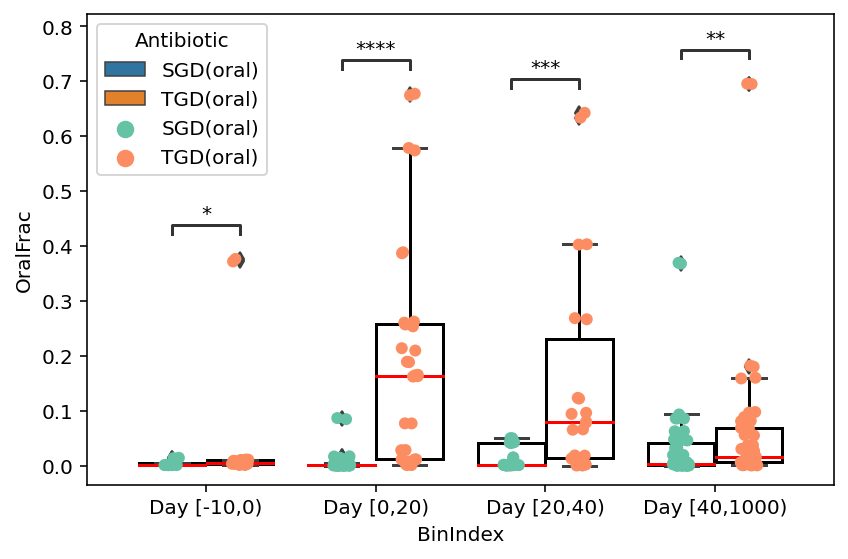

In [11]:
df_bek2 = deepcopy(df_bek)

# SGD/TGD starts 10 days before bone marrow transplant day
df_bek2['Timepoint'] = [int(day.replace('Day','').strip())-10 for day in df_bek2.Timepoint]
df_bek2['Antibiotic'] = [abx.split('--')[0] for abx in df_bek2.Antibiotic]
df_bek2['AntibioticWhen'] = [int(abxw.split('From day 0 to day ')[1].split(',')[0])-10 for abxw in df_bek2.AntibioticWhen]
df_bek2 = df_bek2[df_bek2['BodySubSite']=='Stool']

# since the data is sparse, bin the data first
my_bins = np.array([-10, 0, 20, 40, 1000])
df_bek2['BinIndex'] = np.digitize(df_bek2.Timepoint, bins=my_bins)
df_bek2['BinAbx'] = ['%d_%s'%(b,a) for b,a in zip(df_bek2['BinIndex'], df_bek2['Antibiotic'])]
print(Counter(df_bek2['BinIndex']))
binlabels = ['Day [%d,%d)'%(my_bins[k],my_bins[k+1]) for k,b in enumerate(my_bins) if k!=len(my_bins)-1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), sharey=True)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'r'},
    'whiskerprops':{'color':'k'}
}
_ = sns.boxplot(x='BinIndex', y='OralFrac', hue='Antibiotic', ax=ax, data=df_bek2, **PROPS)
_ = sns.stripplot(x='BinIndex', y='OralFrac', hue='Antibiotic', ax=ax, data=df_bek2, size=6, color=".3", linewidth=0, dodge=True, palette='Set2')
_ = add_stat_annotation(ax, data=df_bek2, x='BinIndex', y='OralFrac', hue='Antibiotic',comparisons_correction=None,
                        box_pairs=[((1,'SGD(oral)'),(1,'TGD(oral)')),
                                   ((2,'SGD(oral)'),(2,'TGD(oral)')),
                                   ((3,'SGD(oral)'),(3,'TGD(oral)')),
                                   ((4,'SGD(oral)'),(4,'TGD(oral)'))
                                  ],
                        test='Kruskal', text_format='star', loc='inside', verbose=1)
_ = ax.set_xticklabels(binlabels)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Bekker2019bbmt_sgd_tgd.svg")

In [12]:
Counter(df_bek2.BinAbx)

Counter({'2_SGD(oral)': 42,
         '4_SGD(oral)': 46,
         '1_SGD(oral)': 8,
         '3_SGD(oral)': 20,
         '2_TGD(oral)': 32,
         '4_TGD(oral)': 52,
         '1_TGD(oral)': 18,
         '3_TGD(oral)': 22})